In [45]:
# # Code to convert this notebook to .py if you want to run it via command line or with Slurm
# from subprocess import call
# command = "jupyter nbconvert train_diff_prior.ipynb --to python"
# call(command,shell=True)

[NbConvertApp] Converting notebook train_diff_prior.ipynb to python
[NbConvertApp] Writing 42279 bytes to train_diff_prior.py


0

# Import packages & functions

In [1]:
import os
import sys
import json
import argparse
import numpy as np
import math
from einops import rearrange
import time
import random
import string
import h5py
from tqdm import tqdm

import webdataset as wds
import gc
import umap
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from diffusers import StableDiffusionXLPipeline


from accelerate import Accelerator, DeepSpeedPlugin

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True

# custom functions #
import utils

/admin/home-mihirneal/miniconda3/envs/mindeye/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/admin/home-mihirneal/miniconda3/envs/mindeye/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
### Multi-GPU config ###
local_rank = os.getenv('RANK')
if local_rank is None: 
    local_rank = 0
else:
    local_rank = int(local_rank)
print("LOCAL RANK ", local_rank)  

num_devices = torch.cuda.device_count()
if num_devices==0: num_devices = 1

# ## UNCOMMENT BELOW SECTION AND COMMENT OUT DEEPSPEED SECTION TO AVOID USING DEEPSPEED ###
accelerator = Accelerator(split_batches=False, mixed_precision="fp16")
global_batch_size = batch_size = 8
data_type = torch.float16 # change depending on your mixed_precision

### DEEPSPEED INITIALIZATION ###
# if num_devices <= 1 and utils.is_interactive():
#     global_batch_size = batch_size = 128
#     print(f"Setting batch_size to {batch_size}")
#     # can emulate a distributed environment for deepspeed to work in jupyter notebook
#     os.environ["MASTER_ADDR"] = "localhost"
#     os.environ["MASTER_PORT"] = str(np.random.randint(10000)+9000)
#     os.environ["RANK"] = "0"
#     os.environ["LOCAL_RANK"] = "0"
#     os.environ["WORLD_SIZE"] = "1"
#     os.environ["GLOBAL_BATCH_SIZE"] = str(global_batch_size) # set this to your batch size!
# else:
#     global_batch_size = os.environ["GLOBAL_BATCH_SIZE"]    
#     batch_size = int(os.environ["GLOBAL_BATCH_SIZE"]) // num_devices

# # alter the deepspeed config according to your global and local batch size
# if local_rank == 0:
#     with open('deepspeed_config_stage2.json', 'r') as file:
#         config = json.load(file)
#     config['train_batch_size'] = int(os.environ["GLOBAL_BATCH_SIZE"])
#     config['train_micro_batch_size_per_gpu'] = batch_size
#     config['bf16'] = {'enabled': False}
#     config['fp16'] = {'enabled': True}
#     with open('deepspeed_config_stage2.json', 'w') as file:
#         json.dump(config, file)
# else:
#     # give some time for the local_rank=0 gpu to prep new deepspeed config file
#     time.sleep(10)
# deepspeed_plugin = DeepSpeedPlugin("deepspeed_config_stage2.json")
# accelerator = Accelerator(split_batches=False)

LOCAL RANK  0


In [3]:
print("PID of this process =",os.getpid())
device = accelerator.device
print("device:",device)
num_workers = num_devices
print(accelerator.state)
world_size = accelerator.state.num_processes
distributed = not accelerator.state.distributed_type == 'NO'

# set data_type to match your mixed precision (automatically set based on deepspeed config)
if accelerator.mixed_precision == "bf16":
    data_type = torch.bfloat16
elif accelerator.mixed_precision == "fp16":
    data_type = torch.float16
else:
    data_type = torch.float32

print("distributed =",distributed, "num_devices =", num_devices, "local rank =", local_rank, "world size =", world_size, "data_type =", data_type)
print = accelerator.print # only print if local_rank=0

PID of this process = 323620
device: cuda
Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

distributed = False num_devices = 1 local rank = 0 world size = 1 data_type = torch.float16


# Configurations

In [4]:
# if running this interactively, can specify jupyter_args here for argparser to use
if utils.is_interactive():
    # create random model_name
    model_name = ''.join(random.choices(string.ascii_letters + string.digits, k=10))
    model_name = model_name + "_interactive"
    print("model_name:", model_name)

    # global_batch_size and batch_size should already be defined in the above cells
    # other variables can be specified in the following string:
    jupyter_args = f"--data_path=/fsx/proj-fmri/shared/mindeyev2_dataset \
                    --model_name={model_name} \
                    --subj=1 --batch_size={batch_size} --no-blurry_recon --no-depth_recon --hidden_dim=4096 \
                    --clip_scale=1. --blur_scale=100. --depth_scale=100. \
                    --max_lr=3e-4 --mixup_pct=.66 --num_epochs=12 --ckpt_interval=999 --no-use_image_aug --no-ckpt_saving"

    jupyter_args = jupyter_args.split()
    print(jupyter_args)
    
    from IPython.display import clear_output # function to clear print outputs in cell
    %load_ext autoreload 
    # this allows you to change functions in models.py or utils.py and have this notebook automatically update with your revisions
    %autoreload 2 

model_name: UxrBr0h0xJ_interactive
['--data_path=/fsx/proj-fmri/shared/mindeyev2_dataset', '--model_name=UxrBr0h0xJ_interactive', '--subj=1', '--batch_size=8', '--no-blurry_recon', '--no-depth_recon', '--hidden_dim=4096', '--clip_scale=1.', '--blur_scale=100.', '--depth_scale=100.', '--max_lr=3e-4', '--mixup_pct=.66', '--num_epochs=12', '--ckpt_interval=999', '--no-use_image_aug', '--no-ckpt_saving']


In [5]:
parser = argparse.ArgumentParser(description="Model Training Configuration")
parser.add_argument(
    "--model_name", type=str, default="testing",
    help="name of model, used for ckpt saving and wandb logging (if enabled)",
)
parser.add_argument(
    "--data_path", type=str, default="/fsx/proj-fmri/shared/natural-scenes-dataset",
    help="Path to where NSD data is stored / where to download it to",
)
parser.add_argument(
    "--subj",type=int, default=1, choices=[1,2,5,7],
)
parser.add_argument(
    "--batch_size", type=int, default=32,
    help="Batch size can be increased by 10x if only training v2c and not diffusion diffuser",
)
parser.add_argument(
    "--wandb_log",action=argparse.BooleanOptionalAction,default=True,
    help="whether to log to wandb",
)
parser.add_argument(
    "--resume_from_ckpt",action=argparse.BooleanOptionalAction,default=False,
    help="if not using wandb and want to resume from a ckpt",
)
parser.add_argument(
    "--wandb_project",type=str,default="stability",
    help="wandb project name",
)
parser.add_argument(
    "--mixup_pct",type=float,default=.33,
    help="proportion of way through training when to switch from BiMixCo to SoftCLIP",
)
parser.add_argument(
    "--blurry_recon",action=argparse.BooleanOptionalAction,default=True,
    help="whether to output blurry reconstructions",
)
parser.add_argument(
    "--depth_recon",action=argparse.BooleanOptionalAction,default=True,
    help="whether to output depth reconstructions",
)
parser.add_argument(
    "--blur_scale",type=float,default=100.,
    help="multiply loss from blurry recons by this number",
)
parser.add_argument(
    "--depth_scale",type=float,default=100.,
    help="multiply loss from depth recons by this number",
)
parser.add_argument(
    "--clip_scale",type=float,default=1.,
    help="multiply contrastive loss by this number",
)
parser.add_argument(
    "--use_image_aug",action=argparse.BooleanOptionalAction,default=True,
    help="whether to use image augmentation",
)
parser.add_argument(
    "--num_epochs",type=int,default=120,
    help="number of epochs of training",
)
parser.add_argument(
    "--hidden_dim",type=int,default=4096,
)
parser.add_argument(
    "--lr_scheduler_type",type=str,default='cycle',choices=['cycle','linear'],
)
parser.add_argument(
    "--ckpt_saving",action=argparse.BooleanOptionalAction,default=True,
)
parser.add_argument(
    "--ckpt_interval",type=int,default=5,
    help="save backup ckpt and reconstruct every x epochs",
)
parser.add_argument(
    "--seed",type=int,default=42,
)
parser.add_argument(
    "--max_lr",type=float,default=3e-5,
)

if utils.is_interactive():
    args = parser.parse_args(jupyter_args)
else:
    args = parser.parse_args()

# create global variables without the args prefix
for attribute_name in vars(args).keys():
    globals()[attribute_name] = getattr(args, attribute_name)

In [6]:
outdir = os.path.abspath(f'../train_logs/{model_name}')
if not os.path.exists(outdir) and ckpt_saving:
    os.makedirs(outdir,exist_ok=True)
if use_image_aug:
    import kornia
    from kornia.augmentation.container import AugmentationSequential
    img_augment = AugmentationSequential(
        kornia.augmentation.RandomResizedCrop((224,224), (0.6,1), p=0.3),
        kornia.augmentation.Resize((224, 224)),
        kornia.augmentation.RandomHorizontalFlip(p=0.3),
        kornia.augmentation.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1, p=0.3),
        kornia.augmentation.RandomGrayscale(p=0.3),
        same_on_batch=False,
        data_keys=["input"],
    )

# Prep data, models, and dataloaders

## Dataloader

In [7]:
if subj==1:
    num_train = 24958
    num_test = 2770
test_batch_size = num_test

def my_split_by_node(urls): return urls
    
train_url = f"{data_path}/wds/subj0{subj}/train/" + "{0..36}.tar"
# train_url = f"{data_path}/wds/subj0{subj}/train/" + "{0..1}.tar"
print(train_url)

train_data = wds.WebDataset(train_url,resampled=False,nodesplitter=my_split_by_node)\
                    .shuffle(750, initial=1500, rng=random.Random(42))\
                    .decode("torch")\
                    .rename(behav="behav.npy", past_behav="past_behav.npy", future_behav="future_behav.npy", olds_behav="olds_behav.npy")\
                    .to_tuple(*["behav", "past_behav", "future_behav", "olds_behav"])
train_dl = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=False, drop_last=True, pin_memory=True)

test_url = f"{data_path}/wds/subj0{subj}/test/" + "0.tar"
print(test_url)

test_data = wds.WebDataset(test_url,resampled=False,nodesplitter=my_split_by_node)\
                    .shuffle(750, initial=1500, rng=random.Random(42))\
                    .decode("torch")\
                    .rename(behav="behav.npy", past_behav="past_behav.npy", future_behav="future_behav.npy", olds_behav="olds_behav.npy")\
                    .to_tuple(*["behav", "past_behav", "future_behav", "olds_behav"])
test_dl = torch.utils.data.DataLoader(test_data, batch_size=test_batch_size, shuffle=False, drop_last=True, pin_memory=True)

/fsx/proj-fmri/shared/mindeyev2_dataset/wds/subj01/train/{0..36}.tar
/fsx/proj-fmri/shared/mindeyev2_dataset/wds/subj01/test/0.tar


### check dataloaders are working

In [8]:
test_vox_indices = []
test_73k_images = []
for test_i, (behav, past_behav, future_behav, old_behav) in enumerate(test_dl):
    test_vox_indices = np.append(test_vox_indices, behav[:,0,5].cpu().numpy())
    test_73k_images = np.append(test_73k_images, behav[:,0,0].cpu().numpy())
test_vox_indices = test_vox_indices.astype(np.int16)
print(test_i, (test_i+1) * test_batch_size, len(test_vox_indices))
print("---\n")

train_vox_indices = []
train_73k_images = []
for train_i, (behav, past_behav, future_behav, old_behav) in enumerate(train_dl):
    train_vox_indices = np.append(train_vox_indices, behav[:,0,5].long().cpu().numpy())
    train_73k_images = np.append(train_73k_images, behav[:,0,0].cpu().numpy())
train_vox_indices = train_vox_indices.astype(np.int16)
print(train_i, (train_i+1) * batch_size, len(train_vox_indices))

0 2770 2770
---

3121 24976 24976


## Load data and images

In [9]:
# load betas
f = h5py.File(f'{data_path}/betas_all_subj0{subj}.hdf5', 'r')
# f = h5py.File(f'{data_path}/betas_subj0{subj}_thresholded_wholebrain.hdf5', 'r')

voxels = f['betas'][:]
print(f"subj0{subj} betas loaded into memory")
voxels = torch.Tensor(voxels).to("cpu").to(data_type)
print("voxels", voxels.shape)
num_voxels = voxels.shape[-1]

# load orig images
f = h5py.File(f'{data_path}/coco_images_224_float16.hdf5', 'r')
images = f['images'][:]
images = torch.Tensor(images).to("cpu").to(data_type)
print("images", images.shape)

subj01 betas loaded into memory
voxels torch.Size([27750, 15724])
images torch.Size([73000, 3, 224, 224])


## Load models

### CLIP image embeddings  model

In [10]:
from models import Clipper
clip_model = Clipper("ViT-L/14", device=torch.device(f"cuda:{local_rank}"), hidden_state=True, norm_embs=True)
# clip_seq_dim = 257
# clip_emb_dim = 768 #1024
hidden_dim = 2048
seq_len=1
prior_mult = 1e-4

from diffusers import StableDiffusionXLPipeline, AutoencoderKL
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16).cuda()
vae.requires_grad_(False)
vae.eval()

pipe = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", vae=vae, torch_dtype=torch.float16
)
pipe = pipe.to("cuda")
plot_umap = True

ViT-L/14 cuda:0


Loading pipeline components...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:17<00:00, 11.13s/it]


### SD VAE

In [11]:
hidden_dim = 2048

In [12]:
# # if blurry_recon:
# #     from diffusers import AutoencoderKL
# #     autoenc = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16, cache_dir="/fsx/proj-fmri/shared/cache")
# #     # autoenc.load_state_dict(torch.load('../train_logs/sdxl_vae_normed/best.pth')["model_state_dict"])
# #     autoenc.eval()
# #     autoenc.requires_grad_(False)
# #     autoenc.to(device)
# #     utils.count_params(autoenc)

# if blurry_recon:# or depth_recon:
#     from diffusers import VQModel
#     autoenc = VQModel.from_pretrained("/fsx/proj-fmri/shared/cache/models--microsoft--vq-diffusion-ithq/snapshots/3f796fb49ee559370dc638dea1d8116af131d993/vqvae", torch_dtype=data_type)
#     autoenc.eval()
#     autoenc.requires_grad_(False)
#     autoenc.to(device)
#     utils.count_params(autoenc)

#### downsampled images

In [13]:
# if blurry_recon:
#     if utils.is_interactive(): display(utils.torch_to_Image(images[[30]]))

#     input_batch = images[[30]].to(device)
#     print(input_batch.shape)

#     downsampled_image = nn.functional.interpolate(input_batch, size=(8, 8), mode='bilinear', align_corners=False)
#     re_upsampled_image = nn.functional.interpolate(downsampled_image, size=(128, 128), mode='nearest')
#     re_upsampled_enc = autoenc.encode(2*re_upsampled_image-1).latents * 0.18215
#     print(re_upsampled_enc.shape)
    
#     if utils.is_interactive(): display(utils.torch_to_Image((autoenc.decode(re_upsampled_enc/0.18215).sample / 2 + 0.5).clamp(0,1)))

#### MiDaS depth

In [14]:
# if depth_recon:
#     from controlnet_aux.midas import MidasDetector
    
#     midas_depth = MidasDetector.from_pretrained(
#       "valhalla/t2iadapter-aux-models", filename="dpt_large_384.pt", model_type="dpt_large", cache_dir="/fsx/proj-fmri/shared/cache").to(device)
#     midas_depth.model.eval()
#     midas_depth.model.requires_grad_(False)
#     midas_depth.model.to(device)
#     pass

In [15]:
# if depth_recon:
#     if utils.is_interactive(): display(utils.torch_to_Image(images[[30]]))

#     input_batch = images[[30,31]].float().to(device)
#     print(input_batch.shape)
    
#     midas_emb = midas_depth.model(input_batch).unsqueeze(1)
#     print(midas_emb.shape)

#     prediction = utils.resize(midas_emb, 32) #/30).clamp(0,1).half() # 30 is roughly prediction.max()
#     print(prediction.shape)
    
#     prediction = (prediction / prediction.view(prediction.shape[0], -1).max(dim=1)[0].view(-1, 1, 1, 1).expand_as(prediction)).half()
#     midas_emb_size = prediction.flatten(1).shape[1]
#     print("midas_emb", prediction.shape, prediction.min(), prediction.max())
#     print("midas_emb_size", midas_emb_size)
    
#     if utils.is_interactive(): display(utils.torch_to_Image(utils.resize(prediction, 224))) 

#     if blurry_recon:
#         prediction = utils.resize(midas_emb, 128).half().repeat(1,3,1,1)
#         prediction = (prediction / prediction.view(prediction.shape[0], -1).max(dim=1)[0].view(-1, 1, 1, 1).expand_as(prediction)).half()
#         prediction_enc = autoenc.encode(2*prediction-1).latents * 0.18215
#         print("vae midas_emb", prediction_enc.shape, prediction_enc.min(), prediction_enc.max())
    
#         if utils.is_interactive(): display(utils.torch_to_Image((autoenc.decode(prediction_enc/0.18215).sample / 2 + 0.5).clamp(0,1)))

### MindEye modules

In [16]:
class MindEyeModule(nn.Module):
    def __init__(self):
        super(MindEyeModule, self).__init__()
    def forward(self, x):
        return x
        
model = MindEyeModule()
model

MindEyeModule()

In [17]:
class RidgeRegression(torch.nn.Module):
    # make sure to add weight_decay when initializing optimizer
    def __init__(self, input_size, out_features): 
        super(RidgeRegression, self).__init__()
        self.out_features = out_features
        self.linear = torch.nn.Linear(input_size, out_features)
    def forward(self, x):
        return self.linear(x)
        
model.ridge = RidgeRegression(voxels.shape[1], out_features=hidden_dim)

utils.count_params(model.ridge)

b = torch.randn((2,1,voxels.shape[1]))
print(b.shape, model.ridge(b).shape)

param counts:
32,204,800 total
32,204,800 trainable
torch.Size([2, 1, 15724]) torch.Size([2, 1, 2048])


In [18]:
from functools import partial
from diffusers.models.vae import Decoder
class BrainNetwork(nn.Module):
    def __init__(self, text, pool, out_dim=2048, in_dim=15724, seq_len=2, h=4096, n_blocks=4, drop=.15, clip_size=2048):
        super().__init__()
        self.is_text = text
        self.is_pool = pool
        self.seq_len = seq_len
        self.h = h
        self.clip_size = clip_size
        
        # Initial linear layer to match the input dimensions to hidden dimensions
        # self.lin0 = nn.Linear(in_dim, seq_len * h)
        
        # Mixer Blocks
        self.mixer_blocks1 = nn.ModuleList([
            self.mixer_block1(h, drop) for _ in range(n_blocks)
        ])
        self.mixer_blocks2 = nn.ModuleList([
            self.mixer_block2(seq_len, drop) for _ in range(n_blocks)
        ])
        
        # Output linear layer
        if self.is_text:
            self.clin1 = nn.Linear(h * seq_len, out_dim, bias=True)
            self.clin2 = nn.Linear(h * seq_len, 768*257, bias=True)
            self.clip_proj = nn.Sequential(
            nn.LayerNorm(768),
            nn.GELU(),
            nn.Linear(768, 2048),
            nn.LayerNorm(2048),
            nn.GELU(),
            nn.Linear(2048, 2048),
            nn.LayerNorm(2048),
            nn.GELU(),
            nn.Linear(2048, 768)
        )
        if self.is_pool:
            self.clin3 = nn.Sequential(
                nn.Linear(h * seq_len, out_dim),
                nn.LayerNorm(out_dim),
                nn.GELU(),
                nn.Linear(out_dim, 1280),
            )

        # low-rank matrices
        # self.rank = 500
        # self.U = nn.Parameter(torch.randn(self.rank, out_dim))
        # self.V = nn.Parameter(torch.randn(h * seq_len, self.rank))
        # self.S = nn.Parameter(torch.randn(out_dim))

        

#         self.text_proj = nn.Sequential(
#             nn.LayerNorm(clip_size),
#             nn.GELU(),
#             nn.Linear(clip_size, 2048),
#             # nn.Dropout(0.5),
#             nn.LayerNorm(2048),
#             nn.GELU(),
#             nn.Linear(2048, 2048),
#             # nn.Dropout(0.5),
#             nn.LayerNorm(2048),
#             nn.GELU(),
#             nn.Linear(2048, clip_size)
#         )

#         self.pooled_proj = nn.Sequential(
#             nn.LayerNorm(157696),
#             nn.GELU(),
#             nn.Linear(157696, h),
#             nn.LayerNorm(h),
#             nn.GELU(),
#             nn.Linear(h, h),
#             nn.LayerNorm(h),
#             nn.GELU(),
#             nn.Linear(h, 1280)
#         )

        
    def mixer_block1(self, h, drop):
        return nn.Sequential(
            nn.LayerNorm(h),
            self.mlp(h, h, drop),  # Token mixing
        )

    def mixer_block2(self, seq_len, drop):
        return nn.Sequential(
            nn.LayerNorm(seq_len),
            self.mlp(seq_len, seq_len, drop)  # Channel mixing
        )
    
    def mlp(self, in_dim, out_dim, drop):
        return nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.GELU(),
            nn.Dropout(drop),
            nn.Linear(out_dim, out_dim),
        )
        
    def forward(self, x):
        # make empty tensors for blur and depth outputs
        
        # Initial linear layer
        # x = self.lin0(x)
        
        # Reshape to seq_len by dim
        # x = x.reshape(-1, self.seq_len, self.h)
        
        # Mixer blocks
        residual1 = x
        residual2 = x.permute(0,2,1)
        for block1, block2 in zip(self.mixer_blocks1,self.mixer_blocks2):
            x = block1(x) + residual1
            residual1 = x
            x = x.permute(0,2,1)
            
            x = block2(x) + residual2
            residual2 = x
            x = x.permute(0,2,1)
        
        # Flatten
        x = x.reshape(x.size(0), -1)
        
        if self.is_text:
            c = self.clin1(x)
            i = self.clin2(x)
            i_proj = self.clip_proj(i.reshape(len(i), -1, 768))
            c = c.reshape(len(c), -1, self.clip_size)
            return c, i_proj

        if self.is_pool:
            c_p = self.clin3(x)
            return c_p


        
b_text = BrainNetwork(text=True, pool=False, h=hidden_dim, in_dim=2048, seq_len=seq_len, clip_size=2048, out_dim=2048*77).cuda()
# b_pool = BrainNetwork(text=False, pool=True, h=hidden_dim, in_dim=2048, seq_len=seq_len, clip_size=2048, out_dim=2048*77).cuda()
utils.count_params(b_text)
# utils.count_params(b_pool)

# test that the model works on some fake data
b = torch.randn((2,seq_len,hidden_dim)).cuda()
print("b.shape",b.shape)
emb, img = b_text(b)
print(emb.shape, img.shape)


param counts:
768,484,376 total
768,484,376 trainable
b.shape torch.Size([2, 1, 2048])
torch.Size([2, 77, 2048]) torch.Size([2, 257, 768])


In [19]:
from models import BrainDiffusionPrior, VersatileDiffusionPriorNetwork
timesteps=100
out_dim = 2048
depth = 6
dim_head = 128
heads=16
heads = out_dim//64


prior_network = VersatileDiffusionPriorNetwork(
            dim=out_dim,
            align="text",
            depth=depth,
            dim_head=dim_head,
            heads=heads,
            causal=False,
            num_tokens = 77,
            learned_query_mode="pos_emb"
        ).to(device)

# prior_network_pool = VersatileDiffusionPriorNetwork(
#             dim=1280,
#             depth=depth,
#             dim_head=128,
#             heads=10,
#             causal=False,
#             num_tokens = 1,
#             learned_query_mode="pos_emb"
#         ).to(device)

print("prior_networks loaded")

model.diffusion_prior_txt = BrainDiffusionPrior(
        net=prior_network,
        image_embed_dim=out_dim,
        condition_on_text_encodings=False,
        timesteps=timesteps,
        cond_drop_prob=0.2,
        image_embed_scale=None,
        voxel2clip=b_text,
).to(device)

# diffusion_prior_pool = BrainDiffusionPrior(
#         net=prior_network_pool,
#         image_embed_dim=1280,
#         condition_on_text_encodings=False,
#         timesteps=timesteps,
#         cond_drop_prob=0.2,
#         image_embed_scale=None,
#         voxel2clip=b_pool,
# ).to(device)

prior_networks loaded


In [20]:
print("params of diffusion prior:")
if local_rank==0:
    utils.count_params(model.diffusion_prior_txt)
    
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
opt_grouped_parameters = [
    {'params': [p for n, p in model.ridge.named_parameters()], 'weight_decay': 1e-2},
    {'params': [p for n, p in model.diffusion_prior_txt.net.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 1e-2},
    {'params': [p for n, p in model.diffusion_prior_txt.net.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
    {'params': [p for n, p in model.diffusion_prior_txt.voxel2clip.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 1e-2},
]

optimizer = torch.optim.AdamW(opt_grouped_parameters, lr=max_lr)

if lr_scheduler_type == 'linear':
    lr_scheduler = torch.optim.lr_scheduler.LinearLR(
        optimizer,
        total_iters=int(np.floor(num_epochs*(num_train/num_devices/batch_size))),
        last_epoch=-1
    )
elif lr_scheduler_type == 'cycle':
    total_steps=int(np.floor(num_epochs*(num_train/num_devices/batch_size)))
    print("total_steps", total_steps)
    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, 
        max_lr=max_lr,
        total_steps=total_steps,
        final_div_factor=1000,
        last_epoch=-1, pct_start=2/num_epochs
    )
        
print("\nDone with model preparations!")

params of diffusion prior:
param counts:
1,212,556,840 total
1,212,556,824 trainable
total_steps 37437

Done with model preparations!


# Weights and Biases

In [21]:
if local_rank==0 and wandb_log: # only use main process for wandb logging
    import wandb
    wandb_project = 'mindeyev2'
    wandb_run = model_name
    wandb_notes = ''
    
    print(f"wandb {wandb_project} run {wandb_run}")
    wandb.login(host='https://stability.wandb.io')#, relogin=True)
    wandb_config = {
      "model_name": model_name,
      "global_batch_size": global_batch_size,
      "batch_size": batch_size,
      "num_epochs": num_epochs,
      "clip_scale": clip_scale,
      "blur_scale": blur_scale,
      "use_image_aug": use_image_aug,
      "max_lr": max_lr,
      "mixup_pct": mixup_pct,
      "num_train": num_train,
      "num_test": num_test,
      "ckpt_interval": ckpt_interval,
      "ckpt_saving": ckpt_saving,
      "seed": seed,
      "distributed": distributed,
      "num_devices": num_devices,
      "world_size": world_size,
      "train_url": train_url,
      "test_url": test_url,
    }
    print("wandb_config:\n",wandb_config)
    if True: # wandb_auto_resume
        print("wandb_id:",model_name)
        wandb.init(
            id = model_name,
            project=wandb_project,
            name=wandb_run,
            config=wandb_config,
            notes=wandb_notes,
            resume="allow",
        )
    else:
        wandb.init(
            project=wandb_project,
            name=wandb_run,
            config=wandb_config,
            notes=wandb_notes,
        )
else:
    wandb_log = False

wandb mindeyev2 run UxrBr0h0xJ_interactive


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mihirneal. Use `wandb login --relogin` to force relogin


wandb_config:
 {'model_name': 'UxrBr0h0xJ_interactive', 'global_batch_size': 8, 'batch_size': 8, 'num_epochs': 12, 'clip_scale': 1.0, 'blur_scale': 100.0, 'use_image_aug': False, 'max_lr': 0.0003, 'mixup_pct': 0.66, 'num_train': 24958, 'num_test': 2770, 'ckpt_interval': 999, 'ckpt_saving': False, 'seed': 42, 'distributed': False, 'num_devices': 1, 'world_size': 1, 'train_url': '/fsx/proj-fmri/shared/mindeyev2_dataset/wds/subj01/train/{0..36}.tar', 'test_url': '/fsx/proj-fmri/shared/mindeyev2_dataset/wds/subj01/test/0.tar'}
wandb_id: UxrBr0h0xJ_interactive


# Main

In [22]:
epoch = 0
losses, test_losses, lrs = [], [], []
best_test_loss = 1e9
soft_loss_temps = utils.cosine_anneal(0.004, 0.0075, num_epochs - int(mixup_pct * num_epochs))

annots = np.load("/fsx/proj-fmri/shared/mindeyev2_dataset/COCO_73k_annots_curated.npy")

def extract_first_non_empty(input_array):    
    non_empty_strings = input_array[input_array != '']
    return non_empty_strings[0] if len(non_empty_strings) > 0 else None

def text_embeds(sdXLpipeline, text):
    txt_emb, _, pool_emb, _= sdXLpipeline.encode_prompt(prompt=text)
    return txt_emb, pool_emb

In [23]:
model, optimizer, train_dl, lr_scheduler = accelerator.prepare(
model, optimizer, train_dl, lr_scheduler)


In [24]:
# def add_saturation(image, alpha=2):
#     gray_image = 0.2989 * image[:, 0, :, :] + 0.5870 * image[:, 1, :, :] + 0.1140 * image[:, 2, :, :]
#     gray_image = gray_image.unsqueeze(1).expand_as(image)
#     saturated_image = alpha * image + (1 - alpha) * gray_image
#     return torch.clamp(saturated_image, 0, 1)

In [25]:
print(f"{model_name} starting with epoch {epoch} / {num_epochs}")
progress_bar = tqdm(range(epoch,num_epochs), ncols=1200, disable=(local_rank!=0))
test_image, test_voxel = None, None
test_cap = []


for epoch in progress_bar:
    model.train()
    
    sims_base = 0.
    val_sims_base = 0.
    fwd_percent_correct = 0.
    bwd_percent_correct = 0.
    val_fwd_percent_correct = 0.
    val_bwd_percent_correct = 0.
    loss_nce_sum = 0.
    loss_prior_sum = 0.
    val_loss_nce_sum = 0.
    val_loss_prior_sum = 0.

    
    for train_i, (behav, past_behav, future_behav, old_behav) in enumerate(train_dl):
        with torch.cuda.amp.autocast(dtype=data_type):
            optimizer.zero_grad()
            repeat_index = train_i % 3
            
            voxel = voxels[behav[:,0,5].cpu().long()].to(device)
            img_id = behav[:,0,0].cpu().long()
            image = images[img_id].to(device).float()
            caps = []
            for i in img_id:
                ann = annots[i]
                cap = extract_first_non_empty(ann)
                caps.append(cap)
            
            if epoch < int(mixup_pct * num_epochs):
                voxel, perm, betas, select = utils.mixco(voxel)

            clip_target = clip_model.embed_image(image).float()
            txt_emb, _ = text_embeds(pipe, caps)

            assert not torch.any(torch.isnan(txt_emb))
            assert not torch.any(torch.isnan(clip_target))
            voxel_ridge = model.ridge(voxel)
            voxel_ridge = voxel_ridge.unsqueeze(1)

            clip_txt_voxels, clip_voxels_proj = model.diffusion_prior_txt.modules.voxel2clip(voxel_ridge) if distributed else model.diffusion_prior_txt.voxel2clip(voxel_ridge)

            loss_txt_prior, aligned_clip_txt_voxels = model.diffusion_prior_txt(text_embed=clip_txt_voxels, image_embed=txt_emb)
            aligned_clip_txt_voxels /= model.diffusion_prior_txt.modules.image_embed_scale if distributed else model.diffusion_prior_txt.image_embed_scale

            clip_voxels_norm = nn.functional.normalize(clip_voxels_proj.flatten(1), dim=-1)
            clip_target_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)

            if epoch < int(mixup_pct * num_epochs):
                loss_nce = utils.mixco_nce(
                    clip_voxels_norm,
                    clip_target_norm,
                    temp=.006, 
                    perm=perm, betas=betas, select=select)
            else:
                epoch_temp = soft_loss_temps[epoch-int(mixup_pct*num_epochs)]
                loss_nce = utils.soft_clip_loss(
                    clip_voxels_norm,
                    clip_target_norm,
                    temp=epoch_temp)
        
            loss_nce_sum += loss_nce.item()
            loss_prior_sum += loss_txt_prior.item()
            loss = loss_nce + (prior_mult * loss_txt_prior)
            
            utils.check_loss(loss)
            accelerator.backward(loss)
            optimizer.step()

            losses.append(loss.item())
            lrs.append(optimizer.param_groups[0]['lr'])

            sims_base += nn.functional.cosine_similarity(clip_target_norm,clip_voxels_norm).mean().item()

            # forward and backward top 1 accuracy        
            labels = torch.arange(len(clip_target_norm)).to(device) 
            fwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_voxels_norm,clip_target_norm), labels, k=1)
            bwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_target_norm, clip_voxels_norm), labels, k=1)
    
            if lr_scheduler_type is not None:
                lr_scheduler.step()

    model.eval()
    if local_rank==0:
        with torch.no_grad(), torch.cuda.amp.autocast(dtype=data_type): 
            for test_i, (behav, past_behav, future_behav, old_behav) in enumerate(test_dl):  
                # all test samples should be loaded per batch such that test_i should never exceed 0
                assert len(behav) == num_test
                
                ## Average same-image repeats ##
                if test_image is None:
                    voxel = voxels[behav[:,0,5].cpu().long()]
                    image = behav[:,0,0].cpu().long()


                    
                    unique_image, sort_indices = torch.unique(image, return_inverse=True)
                    for im in unique_image:
                        locs = torch.where(im == image)[0]
                        if test_image is None:
                            test_image = images[im][None]
                            test_voxel = torch.mean(voxel[locs],axis=0)[None]
                            test_cap.append(extract_first_non_empty(annots[im]))
                            
                        else:
                            test_image = torch.vstack((test_image, images[im][None]))
                            test_cap.append(extract_first_non_empty(annots[im]))
                            test_voxel = torch.vstack((test_voxel, torch.mean(voxel[locs],axis=0)[None]))
    
                # random sample of 300
                random_indices = torch.arange(len(test_voxel))[:8]
                index_list = random_indices.tolist()
                voxel = test_voxel[random_indices].to(device)
                image = test_image[random_indices].to(device)
                cap = [test_cap[i] for i in index_list]
                # assert len(voxel) == 16

                clip_target = clip_model.embed_image(image.float())
                txt_emb, _ = text_embeds(pipe, caps)
                voxel_ridge = model.ridge(voxel).unsqueeze(1)
                
                clip_txt_voxels, clip_voxels_proj = model.diffusion_prior_txt.modules.voxel2clip(voxel_ridge) if distributed else model.diffusion_prior_txt.voxel2clip(voxel_ridge)

                val_loss_txt_prior, aligned_clip_txt_voxels = model.diffusion_prior_txt(text_embed=clip_txt_voxels, image_embed=txt_emb)
                aligned_clip_txt_voxels /= model.diffusion_prior_txt.modules.image_embed_scale if distributed else model.diffusion_prior_txt.image_embed_scale

                clip_voxels_norm = nn.functional.normalize(clip_voxels_proj.flatten(1), dim=-1)
                clip_target_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)

                if epoch < int(mixup_pct * num_epochs):
                    val_loss_nce = utils.mixco_nce(
                        clip_voxels_norm,
                        clip_target_norm,
                        temp=.006, 
                        perm=None, betas=None, select=None)
                else:
                    val_loss_nce = utils.soft_clip_loss(
                        clip_voxels_norm,
                        clip_target_norm,
                        temp=epoch_temp)

                val_loss_nce_sum += val_loss_nce.item()
                val_loss_prior_sum += val_loss_txt_prior.item()
                val_loss = val_loss_nce + (prior_mult * val_loss_txt_prior)

                utils.check_loss(val_loss)                
                test_losses.append(val_loss.item())

            # if utils.is_interactive(): clear_output(wait=True)
            print("---")


            assert (test_i+1) == 1
            logs = {
                "train/lr": lrs[-1],
                "train/num_steps": len(losses),
                "train/loss_prior": loss_prior_sum / (train_i + 1),
                "train/loss_nce": loss_nce_sum / (train_i + 1),
                "test/val_loss_prior": val_loss_prior_sum / (test_i + 1),
                "test/val_loss_nce": val_loss_nce_sum / (test_i + 1)
                }
            
            if wandb_log: wandb.log(logs)
            progress_bar.set_postfix(**logs)
            if plot_umap:
                    print('umap plotting...')
                    combined = np.concatenate((txt_emb.flatten(1).detach().cpu().numpy(),
                                               aligned_clip_txt_voxels.flatten(1).detach().cpu().numpy()),axis=0)
                    reducer = umap.UMAP(random_state=42)
                    embedding = reducer.fit_transform(combined)

                    colors=np.array([[0,0,1,.5] for i in range(len(clip_txt_voxels))])
                    colors=np.concatenate((colors, np.array([[0,1,0,.5] for i in range(len(aligned_clip_txt_voxels))])))

                    fig = plt.figure(figsize=(5,5))
                    plt.scatter(
                        embedding[:, 0],
                        embedding[:, 1],
                        c=colors)
                    if wandb_log:
                        logs[f"val/umap"] = wandb.Image(fig, caption=f"epoch{epoch:03d}")
                        plt.close()
                    else:
                        plt.savefig(os.path.join(outdir, f'umap-val-epoch{epoch:03d}.png'))
                        plt.show()

    # wait for other GPUs to catch up if needed
    accelerator.wait_for_everyone()
    torch.cuda.empty_cache()
    gc.collect()

print("\n===Finished!===\n")

UxrBr0h0xJ_interactive starting with epoch 0 / 12


  0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

---
umap plotting...


/admin/home-mihirneal/miniconda3/envs/mindeye/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
  8%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

ValueError: NaN loss

In [ ]:
accelerator.wait_for_everyone()
if accelerator.is_main_process:
    model = accelerator.unwrap_model(model)
    torch.save(model.state_dict(), "/fsx/proj-fmri/shared/models/fmri-txt-img/diff_text_prior.pth")

In [ ]:
plt.plot(losses)
plt.show()
plt.plot(test_losses)
plt.show()

Exception in thread ChkStopThr:
Traceback (most recent call last):
  File "/admin/home-mihirneal/miniconda3/envs/mindeye/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
Exception in thread NetStatThr:
Traceback (most recent call last):
  File "/admin/home-mihirneal/miniconda3/envs/mindeye/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/admin/home-mihirneal/miniconda3/envs/mindeye/lib/python3.10/threading.py", line 953, in run
    self.run()
  File "/admin/home-mihirneal/miniconda3/envs/mindeye/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/admin/home-mihirneal/miniconda3/envs/mindeye/lib/python3.10/site-packages/wandb/sdk/wandb_run.py", line 170, in check_status
    self._target(*self._args, **self._kwargs)
  File "/admin/home-mihirneal/miniconda3/envs/mindeye/lib/python3.10/site-packages/wandb/sdk/wandb_run.py", line 152, in check_network_status
    status_response = self._interfac

# Retrieve nearest neighbor in the training set using test set data

In [26]:
annots = np.load("/fsx/proj-fmri/shared/mindeyev2_dataset/COCO_73k_annots_curated.npy")

In [ ]:
import os
from PIL import Image
import torch
from torchvision import transforms
import re

def numerical_sort(file):
    # Extract the number from the filename
    number = int(re.search(r'img_t(\d+)', file).group(1))
    return number

def load_and_process_images(directory_path):
    # Check if the directory exists
    if not os.path.exists(directory_path):
        raise Exception(f"The directory does not exist: {directory_path}")

    # Get list of all files in the directory
    file_list = os.listdir(directory_path)

    # Filter out non-image files
    image_files = [file for file in file_list if file.lower().endswith('.jpg')]
    sorted_image_files = sorted(image_files, key=numerical_sort)
    # Define a transformation pipeline
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),  # Resizing the image
        transforms.ToTensor(),  # Converting to tensor
    ])

    # List to hold the tensors
    tensor_list = []

    # Process each image
    # for i in range(118287):
    for i in range(len(sorted_image_files)):
        # Load the image
        with Image.open(os.path.join(directory_path, sorted_image_files[i])).convert("RGB") as img:  # Ensure RGB format
            # Apply the transformations and add to list
            tensor = preprocess(img)
            tensor_list.append(tensor)

    # Stack the individual tensors into a single tensor
    stacked_tensor = torch.stack(tensor_list)

    # Check the shape of the tensor
    print(f"Stacked Tensor Shape: {stacked_tensor.shape}")

    return stacked_tensor

# Replace with your actual directory path
directory_path = '/fsx/proj-fmri/shared/controlNetData/target/'
final_tensor = load_and_process_images(directory_path)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:32<00:00,  1.78s/it]


Original Image (test set)


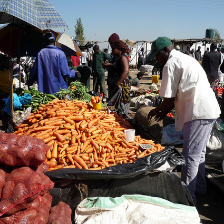

clip_voxels_norm torch.Size([1, 197376])
clip_target_norm torch.Size([8859, 197376])

Nearest neighbors in training set


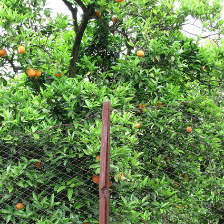

AttributeError: module 'utils' has no attribute 'select_annotations'

In [28]:
ii=0
all_indices = np.unique(train_73k_images) #np.hstack((test_vox_indices[ii],train_vox_indices))
with torch.no_grad(), torch.cuda.amp.autocast():
    for batch in tqdm(range(0,len(all_indices),512)):
        if batch==0:
            clip_target = clip_model.embed_image(images[all_indices[batch:batch+512]]).cpu()
        else:
            target = clip_model.embed_image(images[all_indices[batch:batch+512]]).cpu()
            clip_target = torch.vstack((clip_target,target))
    clip_target_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)

    voxel = test_voxel[[ii]].to(device)
    image = test_image[[ii]].to(device)

    print("Original Image (test set)")
    display(utils.torch_to_Image(image))
    
    clip_target = clip_model.embed_image(image).cpu()
    # clip_target_norm = torch.vstack((clip_target_norm, nn.functional.normalize(clip_target.flatten(1), dim=-1)))
    
    voxel_ridge = model.ridge(voxel).unsqueeze(1)
    clip_voxels, _, _ = model.backbone(voxel_ridge)    
    clip_voxels_norm = nn.functional.normalize(clip_voxels.flatten(1), dim=-1)
    clip_voxels_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)

    print("clip_voxels_norm", clip_voxels_norm.shape)
    print("clip_target_norm", clip_target_norm.shape)
    
    sortt = torch.argsort(utils.batchwise_cosine_similarity(clip_voxels_norm.cpu(), 
                                                            clip_target_norm).flatten()).flip(0)
    picks = all_indices[sortt[:5]]

    print("\nNearest neighbors in training set")
    for ip,p in enumerate(picks):
        display(utils.torch_to_Image(images[[p]]))
        # print(utils.select_annotations([annots[int(p)]]))
        if ip==0: predicted_caption = utils.select_annotations([annots[int(p)]])[0]

print("\n=====\npredicted_caption:\n", predicted_caption)

# Feed into Stable Diffusion XL for reconstructions

In [28]:
from diffusers import StableDiffusionXLPipeline
pipe = StableDiffusionXLPipeline.from_pretrained(
    "/fsx/proj-fmri/shared/cache/models--stabilityai--stable-diffusion-xl-base-1.0/snapshots/f898a3e026e802f68796b95e9702464bac78d76f", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
)
pipe.to("cuda")
pass

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [29]:
prompt = predicted_caption
recon = pipe(prompt=prompt).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

Seen image


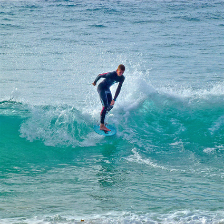

Reconstruction


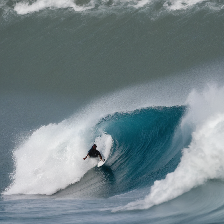

In [30]:
print("Seen image")
display(utils.torch_to_Image(image))

print("Reconstruction")
utils.torch_to_Image(utils.resize(transforms.ToTensor()(recon),224))